# Question 1
1.   Full Name: Farhad Fallah 
2.   Student Number: 97102214

مدل های بخش 1و3و4 در این درایو اپلود شده برای استفاده بعدی بدون نیاز به ران.
https://drive.google.com/drive/folders/16s909zfzOQpdcI1EdT27dpuoa8PGaK2w?usp=sharing

In [1]:
import os
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [2]:
import tensorflow as tf
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense ,Dropout, BatchNormalization,Input,UpSampling2D ,GlobalAveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error,accuracy_score , recall_score , precision_score,confusion_matrix 
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import resnet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy


در این بخش ریپازیتوری مربوط به استفاده از معماری رزنت 18 را ایمپورت میکنیم.

In [5]:
! pip install git+https://github.com/qubvel/classification_models.git



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-fzjvkhdk
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-fzjvkhdk
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.8 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20045 sha256=f45d906780de8c68ab902d6b6e32528e3b48ed4c7b288addbebe3bb249a636c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-kjrsgivf/wheels/77/23/ad/afd2caf2877de1a21565559524b6435e5396579c14207062f3
Successfully built image-classifiers


In [6]:
from classification_models.keras import Classifiers


In [ ]:
'''inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))(inputs)
resnet = resnet50.ResNet50(include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
    )(resize)
resnet.trainable = False
pooling = GlobalAveragePooling2D()(resnet)
flatten = Flatten()(pooling)  
dense = Dense(64, activation="ReLU")(flatten)
output = Dense(10, activation="softmax")(dense)

model = tf.keras.Model(inputs=inputs, outputs = output)'''


In [8]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_X = resnet50.preprocess_input(training_images.astype('float32'))
valid_X = resnet50.preprocess_input(validation_images.astype('float32'))

## Part1
 در بخش اول به کمک رزنت 50 شبکه ای برای داده های آموزش طراحی میکنیم.
 در ابتدا به کمک آپ سمپل سایز ورودی را منطبق بر رزنت میکنیم و در انتها و قبل از لایه سافت مکس هم از یک باتل نک استفاده کرده ایم.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_4 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dense_9 (Dense)             (None, 10)                6

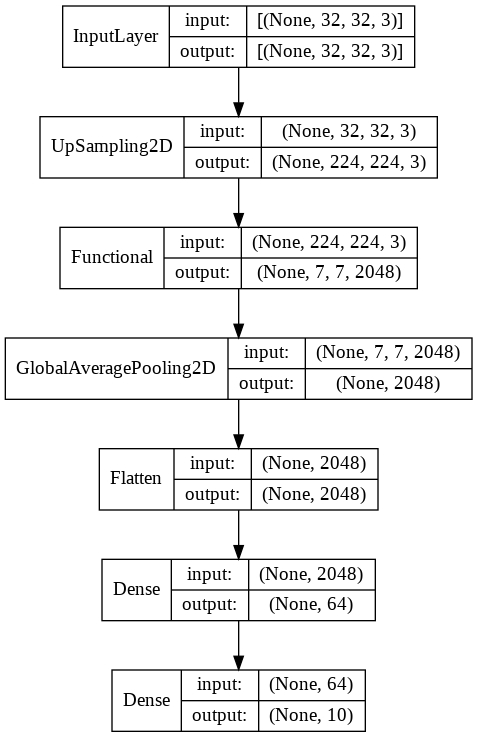

In [ ]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet = resnet50.ResNet50(include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
    )

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="softmax")
model = tf.keras.Sequential([inputs, resize, resnet,pooling,flatten,dense,output])
resnet.trainable = False
model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
model.summary()
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
mch = ModelCheckpoint('teacher.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
history = model.fit(train_X, training_labels, epochs=10 ,callbacks=[mch , es], validation_data = (valid_X, validation_labels), batch_size=128)

Epoch 1/10
391/391 [==============================] - 184s 463ms/step - loss: 0.7406 - accuracy: 0.7449 - val_loss: 0.6545 - val_accuracy: 0.7771
Epoch 2/10
391/391 [==============================] - 185s 473ms/step - loss: 0.5235 - accuracy: 0.8178 - val_loss: 0.5399 - val_accuracy: 0.8104
Epoch 3/10
391/391 [==============================] - 185s 475ms/step - loss: 0.4666 - accuracy: 0.8379 - val_loss: 0.5125 - val_accuracy: 0.8211
Epoch 4/10
391/391 [==============================] - 184s 471ms/step - loss: 0.4308 - accuracy: 0.8489 - val_loss: 0.5141 - val_accuracy: 0.8223
Epoch 5/10
391/391 [==============================] - 185s 472ms/step - loss: 0.4002 - accuracy: 0.8596 - val_loss: 0.5034 - val_accuracy: 0.8276
Epoch 6/10
391/391 [==============================] - 184s 471ms/step - loss: 0.3769 - accuracy: 0.8676 - val_loss: 0.5233 - val_accuracy: 0.8198
Epoch 7/10
391/391 [==============================] - 185s 473ms/step - loss: 0.3540 - accuracy: 0.8754 - val_loss: 0.4902 -

Text(0.5, 1.0, 'Accuracy')

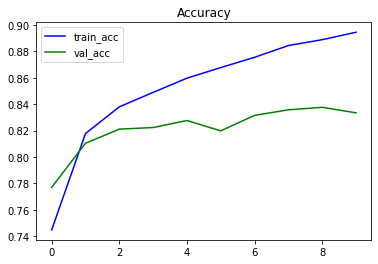

In [ ]:
plt.plot(history.history['accuracy'], color='blue',label = 'train_acc')
plt.plot(history.history['val_accuracy'], color='green' , label = 'val_acc')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

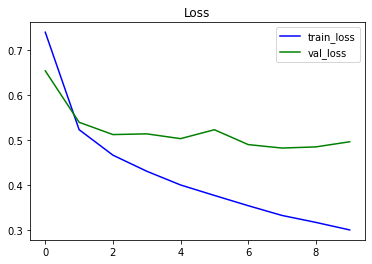

In [ ]:
plt.plot(history.history['loss'], color='blue',label = 'train_loss')
plt.plot(history.history['val_loss'], color='green' , label='val_loss')
plt.legend()
plt.title('Loss')

In [ ]:
#model.save_weights('/content/drive/MyDrive/deep/teacher/weights')


In [ ]:
#model.save('/content/drive/MyDrive/deep/teacher/teacher.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_4 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dense_9 (Dense)             (None, 10)                6

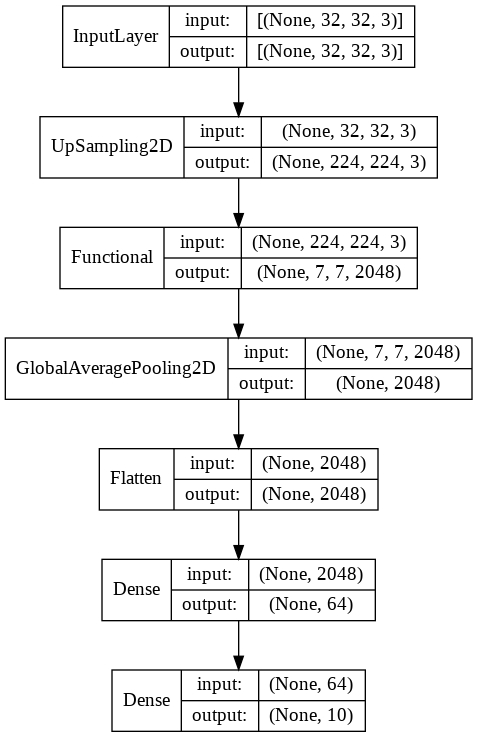

In [9]:
#teacher=load_model('/content/drive/MyDrive/deep/teacher/teacher/teacher.h5')#######file teacher.h5 from given drive
teacher.summary()
plot_model(teacher, show_shapes=True, show_layer_names=False)

In [10]:
loss, accuracy = teacher.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 37s 174ms/step - loss: 0.4965 - accuracy: 0.8334


## Part2
در این بخش به کمک شبکه بخش قبل، شبکه کوچکتر دانش اموز را اموزش میدهیم. برای اینکه بتوانیم از لاجیت های شبکه معلم به درستی استفاده کنیم و سافت لیبل ها را بسازیم تابع فعال سازی لایه اخر را از سافت مکس به خطی تغییر میدهیم و درون خود کلاس اموزش تابع سافت مکس با دمای مناسب به آن اعمال میکنیم.

لازم به ذکر است برای پیاده سازی این کلاس از  مرجع زیر کمک گرفته شده و تغییرات جزیی در ساختار کد با توجه به خواسته های مسئله صورت پذیرفته است.
https://www.kaggle.com/code/bohnphm/knowledge-distillation-with-densenet

In [11]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

In [12]:
teacher.layers[-1].activation = tf.keras.activations.linear
teacher.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_4 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dense_9 (Dense)             (None, 10)                6

In [ ]:
class Distiller(Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        alpha=0.1,
        temperature=3,
    ):
        
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        SCC = SparseCategoricalCrossentropy()
        CC = CategoricalCrossentropy(from_logits=True)
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = SCC(y,  tf.nn.softmax(student_predictions, axis=1))
            
            distillation_loss = (
                CC(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = (1 - self.alpha) * student_loss + (self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss ,"loss": loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        SCC = SparseCategoricalCrossentropy()

        student_loss = SCC(y,  tf.nn.softmax(y_prediction, axis=1))

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

چندین شبکه مختلف با دما و آلفا ی مختلف تست شد، به دلیل قطع شدن مکرر کولب و ارور ها مرتبط با ذخیره سازی نتایج صرفا گزارش یادگیری شبکه موجود است و موفق به نمایش نمودار ها نشدم.
با آموزش شبکه با پارامتر های مختلف این نتیجه حاصل شد که در دمای پایینتر مثلا 3، و افزایش تاثیر بخش سافت لیبیل ها دقت مدل بهتر است.

In [ ]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="linear")
student2 = tf.keras.Sequential([inputs,resize,resnet18,pooling,flatten,dense,output])
distiller = Distiller(student=student2, teacher=teacher)

distiller.compile(
    optimizer='adam',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    alpha=0.1,
    temperature=5,
)
es = EarlyStopping(monitor='val_student_loss', mode='min', patience=5)

# Distill teacher to student
distiller_history = distiller.fit(x= train_X,y=training_labels, 
                                  validation_data=(valid_X , validation_labels), 
                                  batch_size=128, 
                                  epochs=5, callbacks=[ es])

In [ ]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="linear")
student2 = tf.keras.Sequential([inputs,resize,resnet18,pooling,flatten,dense,output])
distiller2 = Distiller(student=student2, teacher=teacher)
distiller2.compile(
    optimizer='adam',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    alpha=0.05,
    temperature=5,
)

es = EarlyStopping(monitor='val_student_loss', mode='min', patience=5)

# Distill teacher to student
distiller_history2 = distiller2.fit(x= train_X,y=training_labels, 
                                  validation_data=(valid_X , validation_labels), 
                                  batch_size=128, 
                                  epochs=5, callbacks=[ es])

Epoch 1/5
391/391 [==============================] - 356s 903ms/step - sparse_categorical_accuracy: 0.4776 - student_loss: 1.4123 - distillation_loss: 56.6062 - loss: 4.1720 - val_sparse_categorical_accuracy: 0.5075 - val_student_loss: 2.7734
Epoch 2/5
391/391 [==============================] - 362s 926ms/step - sparse_categorical_accuracy: 0.6668 - student_loss: 0.9400 - distillation_loss: 55.6021 - loss: 3.6731 - val_sparse_categorical_accuracy: 0.6197 - val_student_loss: 0.9489
Epoch 3/5
391/391 [==============================] - 352s 901ms/step - sparse_categorical_accuracy: 0.7509 - student_loss: 0.7179 - distillation_loss: 54.7614 - loss: 3.4201 - val_sparse_categorical_accuracy: 0.7072 - val_student_loss: 0.8170
Epoch 4/5
391/391 [==============================] - 352s 900ms/step - sparse_categorical_accuracy: 0.8030 - student_loss: 0.5736 - distillation_loss: 54.1131 - loss: 3.2505 - val_sparse_categorical_accuracy: 0.7665 - val_student_loss: 1.2652
Epoch 5/5
391/391 [=========

In [ ]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="linear")
student2 = tf.keras.Sequential([inputs,resize,resnet18,pooling,flatten,dense,output])
distiller3 = Distiller(student=student2, teacher=teacher)
distiller3.compile(
    optimizer='adam',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    alpha=0.1,
    temperature=3,
)
es = EarlyStopping(monitor='val_student_loss', mode='min', patience=5)

# Distill teacher to student
distiller_history3 = distiller3.fit(x= train_X,y=training_labels, 
                                  validation_data=(valid_X , validation_labels), 
                                  batch_size=128, 
                                  epochs=5, callbacks=[ es])


Epoch 1/5
391/391 [==============================] - 338s 822ms/step - sparse_categorical_accuracy: 0.4942 - student_loss: 1.3810 - distillation_loss: 19.8286 - loss: 3.2257 - val_sparse_categorical_accuracy: 0.4519 - val_student_loss: 2.5055
Epoch 2/5
391/391 [==============================] - 327s 836ms/step - sparse_categorical_accuracy: 0.6798 - student_loss: 0.9133 - distillation_loss: 18.9709 - loss: 2.7191 - val_sparse_categorical_accuracy: 0.6592 - val_student_loss: 0.9313
Epoch 3/5
391/391 [==============================] - 327s 836ms/step - sparse_categorical_accuracy: 0.7592 - student_loss: 0.7036 - distillation_loss: 18.4605 - loss: 2.4793 - val_sparse_categorical_accuracy: 0.6162 - val_student_loss: 0.6221
Epoch 4/5
391/391 [==============================] - 328s 838ms/step - sparse_categorical_accuracy: 0.8115 - student_loss: 0.5631 - distillation_loss: 18.0738 - loss: 2.3142 - val_sparse_categorical_accuracy: 0.6982 - val_student_loss: 0.9171
Epoch 5/5
391/391 [=========

In [ ]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="linear")
student2 = tf.keras.Sequential([inputs,resize,resnet18,pooling,flatten,dense,output])
distiller4 = Distiller(student=student2, teacher=teacher)
distiller4.compile(
    optimizer='adam',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    alpha=0.2,
    temperature=3,
)
es = EarlyStopping(monitor='val_student_loss', mode='min', patience=5)

# Distill teacher to student
distiller_history4 = distiller4.fit(x= train_X,y=training_labels, 
                                  validation_data=(valid_X , validation_labels), 
                                  batch_size=128, 
                                  epochs=5, callbacks=[ es])


Epoch 1/5
391/391 [==============================] - 323s 811ms/step - sparse_categorical_accuracy: 0.5049 - student_loss: 1.3702 - distillation_loss: 19.6599 - loss: 5.0281 - val_sparse_categorical_accuracy: 0.5067 - val_student_loss: 1.7877
Epoch 2/5
391/391 [==============================] - 327s 836ms/step - sparse_categorical_accuracy: 0.6796 - student_loss: 0.9427 - distillation_loss: 18.6785 - loss: 4.4899 - val_sparse_categorical_accuracy: 0.5476 - val_student_loss: 0.9989
Epoch 3/5
391/391 [==============================] - 327s 837ms/step - sparse_categorical_accuracy: 0.7620 - student_loss: 0.7347 - distillation_loss: 18.1416 - loss: 4.2161 - val_sparse_categorical_accuracy: 0.6585 - val_student_loss: 0.8234
Epoch 4/5
391/391 [==============================] - 328s 838ms/step - sparse_categorical_accuracy: 0.8098 - student_loss: 0.6008 - distillation_loss: 17.8005 - loss: 4.0408 - val_sparse_categorical_accuracy: 0.6871 - val_student_loss: 1.5259
Epoch 5/5
391/391 [=========

In [ ]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="linear")
student2 = tf.keras.Sequential([inputs,resize,resnet18,pooling,flatten,dense,output])
distiller5 = Distiller(student=student2, teacher=teacher)
distiller5.compile(
    optimizer='adam',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    alpha=0.5,
    temperature=3,
)
es = EarlyStopping(monitor='val_student_loss', mode='min', patience=5)

# Distill teacher to student
distiller_history5 = distiller5.fit(x= train_X,y=training_labels, 
                                  validation_data=(valid_X , validation_labels), 
                                  batch_size=128, 
                                  epochs=5, callbacks=[ es])


Epoch 1/5
391/391 [==============================] - 330s 834ms/step - sparse_categorical_accuracy: 0.4974 - student_loss: 1.6019 - distillation_loss: 19.2277 - loss: 10.4148 - val_sparse_categorical_accuracy: 0.4058 - val_student_loss: 6.1335
Epoch 2/5
391/391 [==============================] - 328s 839ms/step - sparse_categorical_accuracy: 0.6835 - student_loss: 1.1959 - distillation_loss: 18.0903 - loss: 9.6431 - val_sparse_categorical_accuracy: 0.5103 - val_student_loss: 2.5164
Epoch 3/5
391/391 [==============================] - 328s 838ms/step - sparse_categorical_accuracy: 0.7684 - student_loss: 0.9462 - distillation_loss: 17.5921 - loss: 9.2692 - val_sparse_categorical_accuracy: 0.7146 - val_student_loss: 1.1537
Epoch 4/5
391/391 [==============================] - 328s 839ms/step - sparse_categorical_accuracy: 0.8176 - student_loss: 0.7649 - distillation_loss: 17.3441 - loss: 9.0545 - val_sparse_categorical_accuracy: 0.7083 - val_student_loss: 2.4201
Epoch 5/5
391/391 [========

In [ ]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="linear")
student2 = tf.keras.Sequential([inputs,resize,resnet18,pooling,flatten,dense,output])
distiller6 = Distiller(student=student2, teacher=teacher)
distiller6.compile(
    optimizer='adam',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    alpha=0.7,
    temperature=3,
)
es = EarlyStopping(monitor='val_student_loss', mode='min', patience=5)

# Distill teacher to student
distiller_history6 = distiller6.fit(x= train_X,y=training_labels, 
                                  validation_data=(valid_X , validation_labels), 
                                  batch_size=128, 
                                  epochs=5, callbacks=[ es])


Epoch 1/5
391/391 [==============================] - 332s 840ms/step - sparse_categorical_accuracy: 0.5228 - student_loss: 1.9806 - distillation_loss: 18.7820 - loss: 13.7416 - val_sparse_categorical_accuracy: 0.5456 - val_student_loss: 3.9659
Epoch 2/5
391/391 [==============================] - 328s 840ms/step - sparse_categorical_accuracy: 0.6982 - student_loss: 1.5291 - distillation_loss: 17.7477 - loss: 12.8821 - val_sparse_categorical_accuracy: 0.6700 - val_student_loss: 2.4646
Epoch 3/5
391/391 [==============================] - 329s 841ms/step - sparse_categorical_accuracy: 0.7778 - student_loss: 1.1840 - distillation_loss: 17.3591 - loss: 12.5066 - val_sparse_categorical_accuracy: 0.7316 - val_student_loss: 2.0591
Epoch 4/5
391/391 [==============================] - 329s 841ms/step - sparse_categorical_accuracy: 0.8181 - student_loss: 0.9736 - distillation_loss: 17.1778 - loss: 12.3166 - val_sparse_categorical_accuracy: 0.7455 - val_student_loss: 1.5492
Epoch 5/5
391/391 [=====

In [ ]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="linear")
student2 = tf.keras.Sequential([inputs,resize,resnet18,pooling,flatten,dense,output])
distiller7 = Distiller(student=student2, teacher=teacher)
distiller7.compile(
    optimizer='adam',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    alpha=0.9,
    temperature=3,
)
es = EarlyStopping(monitor='val_student_loss', mode='min', patience=5)

# Distill teacher to student
distiller_history7 = distiller7.fit(x= train_X,y=training_labels, 
                                  validation_data=(valid_X , validation_labels), 
                                  batch_size=128, 
                                  epochs=5, callbacks=[ es])


Epoch 1/5
391/391 [==============================] - 333s 842ms/step - sparse_categorical_accuracy: 0.4780 - student_loss: 3.1883 - distillation_loss: 18.7346 - loss: 17.1799 - val_sparse_categorical_accuracy: 0.3808 - val_student_loss: 11.2827
Epoch 2/5
391/391 [==============================] - 328s 839ms/step - sparse_categorical_accuracy: 0.6516 - student_loss: 2.6506 - distillation_loss: 17.7774 - loss: 16.2647 - val_sparse_categorical_accuracy: 0.6280 - val_student_loss: 3.6435
Epoch 3/5
391/391 [==============================] - 328s 839ms/step - sparse_categorical_accuracy: 0.7219 - student_loss: 2.1650 - distillation_loss: 17.4404 - loss: 15.9128 - val_sparse_categorical_accuracy: 0.7177 - val_student_loss: 5.1456
Epoch 4/5
391/391 [==============================] - 329s 841ms/step - sparse_categorical_accuracy: 0.7710 - student_loss: 1.8096 - distillation_loss: 17.2391 - loss: 15.6962 - val_sparse_categorical_accuracy: 0.6960 - val_student_loss: 3.0950
Epoch 5/5
391/391 [====

## Part3:
 در ادامه شبکه دانش اموز را از ابتدا آموزش میدهیم. در این گزارش و این خروجی دقت این روش از روش قبل کمتر شد ولی بعضا در همین 5 ایپاک دقت بهتری نسبت به نتایج بخش قبلی حاصل شد.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 model_2 (Functional)        (None, 7, 7, 512)         11186889  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 10)               

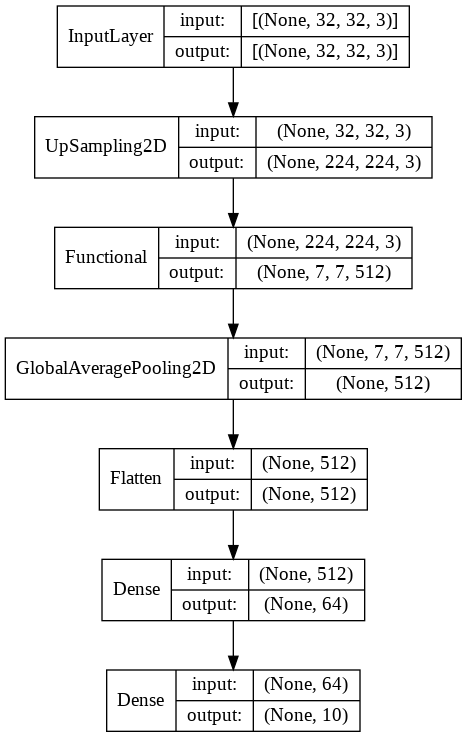

In [15]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet18 = ResNet18((224, 224, 3), weights=None,include_top = False)

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="softmax")
student = tf.keras.Sequential([inputs,resize,resnet18,pooling,flatten,dense,output])
student.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
student.summary()
plot_model(student, show_shapes=True, show_layer_names=False)

In [16]:
mch = ModelCheckpoint('student_normaltrain.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

history = student.fit(train_X, training_labels, epochs=5,callbacks=[mch , es], validation_data = (valid_X, validation_labels), batch_size=128)

Epoch 1/5
391/391 [==============================] - 188s 467ms/step - loss: 1.3220 - accuracy: 0.5146 - val_loss: 2.2249 - val_accuracy: 0.4264
Epoch 2/5
391/391 [==============================] - 180s 459ms/step - loss: 0.8603 - accuracy: 0.6949 - val_loss: 1.1736 - val_accuracy: 0.6107
Epoch 3/5
391/391 [==============================] - 180s 459ms/step - loss: 0.6404 - accuracy: 0.7785 - val_loss: 0.8590 - val_accuracy: 0.7171
Epoch 4/5
391/391 [==============================] - 179s 458ms/step - loss: 0.5108 - accuracy: 0.8215 - val_loss: 1.1650 - val_accuracy: 0.6560
Epoch 5/5
391/391 [==============================] - 179s 458ms/step - loss: 0.4132 - accuracy: 0.8559 - val_loss: 1.0067 - val_accuracy: 0.6977


In [ ]:
#student.save_weights('/content/drive/MyDrive/deep/student_normaltrain/weights')


In [ ]:
#student.save('/content/drive/MyDrive/deep/student_normaltrain/student_normaltrain.h5')

## Part4:
در بخش اخر کل شبکه معلم را فاین تیون میکنیم،مطابق انتظار دقت شبکه از شبکه بخش اول بهتر است ولی به شدت کندتر آموزش انجام میشود،4 ایپاک این پروسه از کل پروسه ی بخش اول بیشتر طول کشید اما دقت بهتری حاصل شد.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_4 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dense_9 (Dense)             (None, 10)               

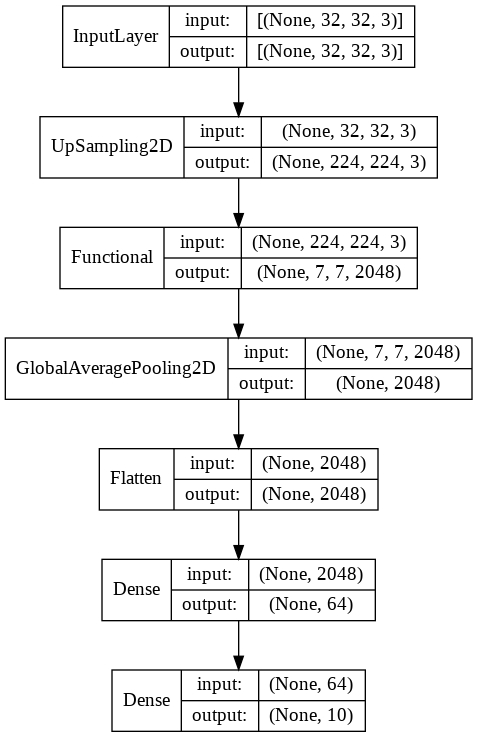

In [23]:
inputs = Input(shape=(32,32,3))
resize = UpSampling2D(size=(7,7))
resnet = resnet50.ResNet50(include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
    )

pooling = GlobalAveragePooling2D()
flatten = Flatten()
dense = Dense(64, activation="ReLU")
output = Dense(10, activation="softmax")
model = tf.keras.Sequential([inputs, resize, resnet,pooling,flatten,dense,output])
model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
model.summary()
plot_model(model, show_shapes=True, show_layer_names=False)

In [24]:
mch = ModelCheckpoint('teacher_finetune.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
history = model.fit(train_X, training_labels, epochs=3,callbacks=[mch , es], validation_data = (valid_X, validation_labels), batch_size=128)

Epoch 1/3
391/391 [==============================] - 526s 1s/step - loss: 0.5953 - accuracy: 0.8007 - val_loss: 1.2681 - val_accuracy: 0.6356
Epoch 2/3
391/391 [==============================] - 516s 1s/step - loss: 0.3160 - accuracy: 0.8926 - val_loss: 0.5753 - val_accuracy: 0.8139
Epoch 3/3
391/391 [==============================] - 516s 1s/step - loss: 0.2093 - accuracy: 0.9277 - val_loss: 0.5490 - val_accuracy: 0.8371


In [25]:
history = model.fit(train_X, training_labels, epochs=1,callbacks=[mch , es], validation_data = (valid_X, validation_labels), batch_size=128)

391/391 [==============================] - 531s 1s/step - loss: 0.1617 - accuracy: 0.9427 - val_loss: 0.4627 - val_accuracy: 0.8572


In [ ]:
#student=load_model('/content/drive/MyDrive/deep/teacher/teacher/student_normaltrain.h5')#######file student_normaltrain.h5 from given drive
student.summary()
plot_model(teacher, show_shapes=True, show_layer_names=False)